<a href="https://colab.research.google.com/github/savpatpanda/protein/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/savpatpanda/protein.git
%cd protein
!ls 
!pip3 install -r requirements.txt
# to push to GitHub, File > Save a copy in GitHub

Cloning into 'protein'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 59 (delta 27), reused 30 (delta 10), pack-reused 0
Unpacking objects: 100% (59/59), done.
/content/protein
data  notebook.ipynb  plotting.py  proteinModel.py  requirements.txt
     |████████████████████████████████| 1.8MB 2.7MB/s 
     |████████████████████████████████| 11.6MB 14.1MB/s 
     |████████████████████████████████| 14.5MB 251kB/s 
     |████████████████████████████████| 2.2MB 45.3MB/s 
     |████████████████████████████████| 296kB 44.7MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installati

In [26]:
import numpy as np
def getFractionalToCartesianRotationMatrix(a, b, c, alpha, beta, gamma):
  alpha = alpha*np.pi/180
  beta  = beta*np.pi/180
  gamma  = gamma*np.pi/180

  n2 = (np.cos(alpha) - np.cos(gamma) * np.cos(beta)) / np.sin(gamma)
  M  = np.array([ [a,0,0],
                  [b*np.cos(gamma),b*np.sin(gamma),0], 
                  [c*np.cos(beta), c*n2, c*np.sqrt(np.sin(beta)**2-n2**2)]
                 ])
  return M


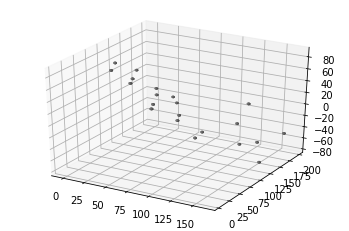

In [47]:
from gemmi import cif 
from plotting import plotSpheres
import matplotlib.pyplot as plt

parseCIFNum = lambda num: float(num[:-4] if num[-1] == ')' else num)

def parseCIFFile(cifFileName):
  doc = cif.read_file("./data/185472.cif")
  block = doc.sole_block()
  fractionalSpace = [ block.find_pair("_cell_length_a"),
                      block.find_pair("_cell_length_b"),
                      block.find_pair("_cell_length_c"),
                      block.find_pair("_cell_angle_alpha"),
                      block.find_pair("_cell_angle_beta"),
                      block.find_pair("_cell_angle_gamma")]

  fractionalSpace = map(lambda x: parseCIFNum(x[1]), fractionalSpace)
  rotationMatrix = getFractionalToCartesianRotationMatrix(*fractionalSpace)
  
  x = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_x"))]
  y = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_y"))]
  z = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_z"))]
  coords = np.array(list(zip(x,y,z)))

  return coords, rotationMatrix
  
try:
  coords, rotationMatrix = parseCIFFile("./data/185472.cif")
  cartesian = np.matmul(coords, rotationMatrix)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  plotSpheres(cartesian * 30, ax)
  plt.show()
  
except Exception as e:
  print(e)